# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        #[0,1,...,narms-1]
        self.epsilon = epsilon
        self.qvalue = np.full(narms, Q0, dtype=float)
        self.visited = np.full(narms, 0)
        
    def play(self, tround, context=None):
        random_num = np.random.random()
        if random_num < self.epsilon: # or tround == 1:
            return np.random.randint(0, self.narms)
        else:
            expected_qvalue = self.qvalue/self.visited
            candidates = np.argwhere(expected_qvalue == np.amax(expected_qvalue)).flatten().tolist()
            if len(candidates) == 1:
                return candidates[0]
            else:
                return np.random.choice(candidates)
        
    def update(self, arm, reward, context=None):
        self.visited[arm] += 1
        if self.visited[arm] == 1:
            self.qvalue[arm] = reward
        else:
            self.qvalue[arm] += reward
        return
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.visit_record = np.full(narms, 0)
        self.qvalue = np.full(narms, Q0, dtype=float)
        self.rho = rho

    def play(self, tround, context=None):
        expected_qvalue = np.full(self.narms, 0.0)
        for i in range(self.narms):
            if self.visit_record[i] == 0:
                expected_qvalue[i] = np.inf
            else:
                expected_qvalue[i] = self.qvalue[i] / self.visit_record[i] + np.sqrt(self.rho * np.log(tround) / self.visit_record[i])
        candidates = np.argwhere(expected_qvalue == np.amax(expected_qvalue)).flatten().tolist()
        if len(candidates) == 1:
            return candidates[0]
        else:
            return np.random.choice(candidates)

    def update(self, arm, reward, context=None):
        self.visit_record[arm] += 1
        if self.visit_record[arm] == 1:
            self.qvalue[arm] = reward
        else:
            self.qvalue[arm] += reward  

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    round_count = 1
    results = []
    checked_record = 0
    for i in range(len(arms)):
        checked_record += 1

        context = np.split(contexts[i], 10)

        arm = arms[i]-1
        mab_arm = mab.play(round_count, context)
        if mab_arm == int(arm):
            results.append(rewards[i])
            mab.update(mab_arm, rewards[i], context)
            round_count += 1
            if nrounds and round_count > nrounds:
                break
        else:
            #results.append(0)
            # print('not same arm', mab_arm, int(arm))
            continue
    print(round_count-1, ' out of total ', checked_record)
    # print('offline eval', np.shape(results))
    return results

In [6]:
dataset = np.loadtxt('dataset.txt', dtype='int')
arms = dataset[:, 0]
rewards = dataset[:, 1]
contexts = dataset[:, 2:]

mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

800  out of total  8213
EpsGreedy average reward 0.14125


In [7]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

800  out of total  8467
UCB average reward 0.17375


## 3. Contextual Bandits

In [8]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha

        self.arm_matrix = np.full((narms, ndims, ndims), np.identity(ndims))
        self.qvalue = np.full((narms, ndims), np.full(ndims, 0))

    def play(self, tround, context):
        pvalue = np.full(self.narms, 0.0)
        for i in range(self.narms):
            inversed_arm = inv(self.arm_matrix[i])
            theta = inversed_arm.dot(self.qvalue[i])
            rewards = theta.dot(context[i]) + self.alpha * np.sqrt(context[i].dot(inversed_arm).dot(context[i]))
            pvalue[i] = rewards

        candidates = np.argwhere(pvalue == np.amax(pvalue)).flatten().tolist()
        if len(candidates) == 1:
            return candidates[0]
        else:
            # print('random')
            return np.random.choice(candidates)

    def update(self, arm, reward, context):
        self.arm_matrix[arm] += np.outer(context[arm], context[arm])
        self.qvalue[arm] += reward * context[arm]
        return

In [9]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

800  out of total  7901
LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

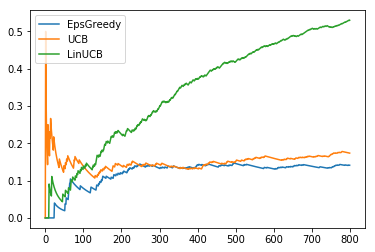

In [10]:
def get_y(results, rounds):
    cumulative_results = np.cumsum(results)
    return cumulative_results.astype(float)/(np.arange(rounds)+1)


EpsGreedy_y = get_y(results_EpsGreedy, 800)
UCB_y = get_y(results_UCB, 800)
LinUCB_y = get_y(results_LinUCB, 800)

x_axis = np.arange(800)
plt.plot(x_axis, EpsGreedy_y, label='EpsGreedy')
plt.plot(x_axis, UCB_y, label='UCB')
plt.plot(x_axis, LinUCB_y, label='LinUCB')
plt.legend(loc='upper left')
plt.show()

### 4.B.

In [11]:
def grid_search(arms, rewards, contexts, low, high):
    results = []
    for alpha in np.arange(low, high, 0.1):
        mab = LinUCB(10, 10, alpha)
        avg = np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800))
        print(avg)
        results.append((alpha, avg))

    results.sort(key=lambda tup: tup[1], reverse=True)
    return results[0]

print('optimal alpha', grid_search(arms, rewards, contexts, 0, 1.5)[0])

800  out of total  7963
0.64375
800  out of total  7761
0.70875
800  out of total  7759
0.6775
800  out of total  7706
0.64375
800  out of total  7661
0.635
800  out of total  7775
0.6225
800  out of total  7863
0.6075
800  out of total  7778
0.57625
800  out of total  7844
0.55875
800  out of total  7968
0.53625
800  out of total  7901
0.53
800  out of total  7801
0.49875
800  out of total  7649
0.4775
800  out of total  7729
0.46
800  out of total  7830
0.4475
optimal alpha 0.1


## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.u_value = np.full(narms, 0.0)
        self.u_value[0] = 1
        self.y_value = list()
        self.x_context = []
        self.prev_K = None


    def play(self, tround, context):
        if tround == 1:
            return 1
        else:
            candidates = np.argwhere(self.u_value == np.amax(self.u_value)).flatten().tolist()
            return np.random.choice(candidates)


    def update(self, arm, reward, context):
        self.x_context.append(context[arm])
        self.y_value.append(reward)
        k_xt_t = list()
        for i in range(len(self.y_value)):
            k_xt_t.append(self.kern([context[arm]], [self.x_context[i]])[0][0])
        if len(self.y_value) == 1:
            K_matrix = inv(self.kern([context[arm]], [context[arm]]) + self.gamma)
            print('kmatrix',K_matrix)
        else:
            b = np.array(k_xt_t[:-1])
            K_22 = inv(self.kern([context[arm]], [context[arm]])[0][0] + self.gamma - b.T.dot(self.prev_K).dot(b))
            K_11 = self.prev_K + K_22.dot(self.prev_K).dot(b).dot(b.T).dot(self.prev_K)
            K_12 = -(K_22.dot(self.prev_K).dot(b))
            K_21 = -(K_22.dot(b.T).dot(self.prev_K))
            K_matrix = np.block([K_11, K_12],[K_21, K_22])

        for i in range(self.narms):
            k_xn_t = np.array([self.kern([context[i]], [context[j]])[0][0] for j in range(self.narms)])
            print('shape', np.shape(k_xn_t.T.dot(K_matrix[0]).dot(k_xn_t)))
            theta = np.sqrt(self.kern([context[i]], [context[i]])[0][0] - k_xn_t.T.dot(K_matrix[0]).dot(k_xn_t))
            self.u_value[i] = k_xn_t.T.dot(K_matrix).dot(reward) + (self.eta * np.sqrt(self.gamma)) * theta

        self.prev_K = K_matrix


        pass


mab = KernelUCB(10, 10, 1, 1, rbf_kernel)
result_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        
    